### Analysis of the SR data (raw and smooth)
The SR methylation calls from BSsmooth were taken for EMSeq and TruSeq (no TruMethyl since distinct samples are absent). Our aim is to compare methylation difference (DMRs) using Metilene, and see if smoothing makes a differences in called DMRs.

In [1]:
# RUN FIRST TIME
# install.packages("tidyverse")
# install.packages("wesanderson")
# install.packages("cowplot")
# BiocManager::install("GenomicRanges")
# BiocManager::install("ggbio")


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cloud.r-project.org

Bioconductor version 3.19 (BiocManager 1.30.26), R 4.4.2 (2024-10-31)

Installing package(s) 'ggbio'

Old packages: 'coloc', 'crosstalk', 'curl', 'epiR', 'evaluate', 'flextable',
  'gdtools', 'incidence', 'later', 'MendelianRandomization', 'PKI',
  'RcppArmadillo', 'RcppEigen', 'rprojroot', 'rsconnect', 'rvest',
  'spatstat.data', 'spelling', 'usethis', 'V8', 'xfun', 'xml2', 'boot',
  'lattice', 'Matrix', 'mgcv', 'spatial'



In [7]:
# Load packages
library(ggplot2)
library(data.table)
library(tidyverse)
library(wesanderson)
library(RColorBrewer)
library(viridis)
library(cowplot)
library(GenomicRanges)
library(ggbio)


In [3]:
#
getwd()
metilene_out1 = list.files(path="outputs/metilene/results", pattern="\\.sr\\.metilene\\.out\\.tsv", full.names = TRUE, recursive=FALSE, ignore.case = FALSE)
metilene_out1


[1] "/opt/notebooks"

[1] "outputs/metilene/results/GSM5649427_TruSeq_HG005_LAB01_REP02__GSM5649436_TruSeq_HG002_LAB01_REP02.raw.sr.metilene.out.tsv"     
[2] "outputs/metilene/results/GSM5649427_TruSeq_HG005_LAB01_REP02__GSM5649436_TruSeq_HG002_LAB01_REP02.smoothed.sr.metilene.out.tsv"
[3] "outputs/metilene/results/GSM5649520_EMSeq_HG002_LAB01_REP01__GSM5649571_EMSeq_HG005_LAB02_REP01.raw.sr.metilene.out.tsv"       
[4] "outputs/metilene/results/GSM5649520_EMSeq_HG002_LAB01_REP01__GSM5649571_EMSeq_HG005_LAB02_REP01.smoothed.sr.metilene.out.tsv"

In [4]:
#
df_file_stats <- data.frame(
  Group1 = character(), Group2 = character(), Type = character(), Seq = character(),
  count_total_calls = numeric(), count_signf_calls = numeric(), stringsAsFactors = FALSE
)

df_file_stats <- lapply(metilene_out1, function(file1) {
  row_df1 <- data.frame(
    Group1 = NA, Group2 = NA, Type = NA, Seq = NA,
    count_total_calls = 0, count_signf_calls = 0, stringsAsFactors = FALSE
  )
  
  size1 <- file.info(file1)$size
  if (size1 > 0) {
    df1 <- read.table(file1, header = FALSE)
    row_df1$count_total_calls <- nrow(df1)
    row_df1$count_signf_calls <- nrow(dplyr::filter(df1, V4 <= 0.1))
  }
  
  # Extract metadata from filename
  row_df1$Group1 <- sub("__.*", "", basename(file1))
  row_df1$Group1 <- sub(".*_HG", "HG", row_df1$Group1)
  row_df1$Group1 <- sub("_.*", "", row_df1$Group1)    
  row_df1$Group2 <- sub("\\..*", "", sub(".*__", "", basename(file1)))
  row_df1$Group2 <- sub(".*_HG", "HG", row_df1$Group2)
  row_df1$Group2 <- sub("_.*", "", row_df1$Group2)    
  row_df1$Type <- sub(".*\\.", "", sub(".sr.metilene.out.tsv", "", basename(file1)))
  row_df1$Seq <- sub(".*_", "", sub("_HG00[0-9].*", "", basename(file1)))
  
  return(row_df1)
})

df_file_stats <- do.call(rbind, df_file_stats)
df_file_stats <- df_file_stats |>
  dplyr::mutate(Group = paste(Group1, Group2, sep = "_"))

#
df_file_stats


Group1,Group2,Type,Seq,count_total_calls,count_signf_calls,Group
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
HG005,HG002,raw,TruSeq,2206,18,HG005_HG002
HG005,HG002,smoothed,TruSeq,0,0,HG005_HG002
HG002,HG005,raw,EMSeq,4199,61,HG002_HG005
HG002,HG005,smoothed,EMSeq,0,0,HG002_HG005


agg_record_737316557 
                   2

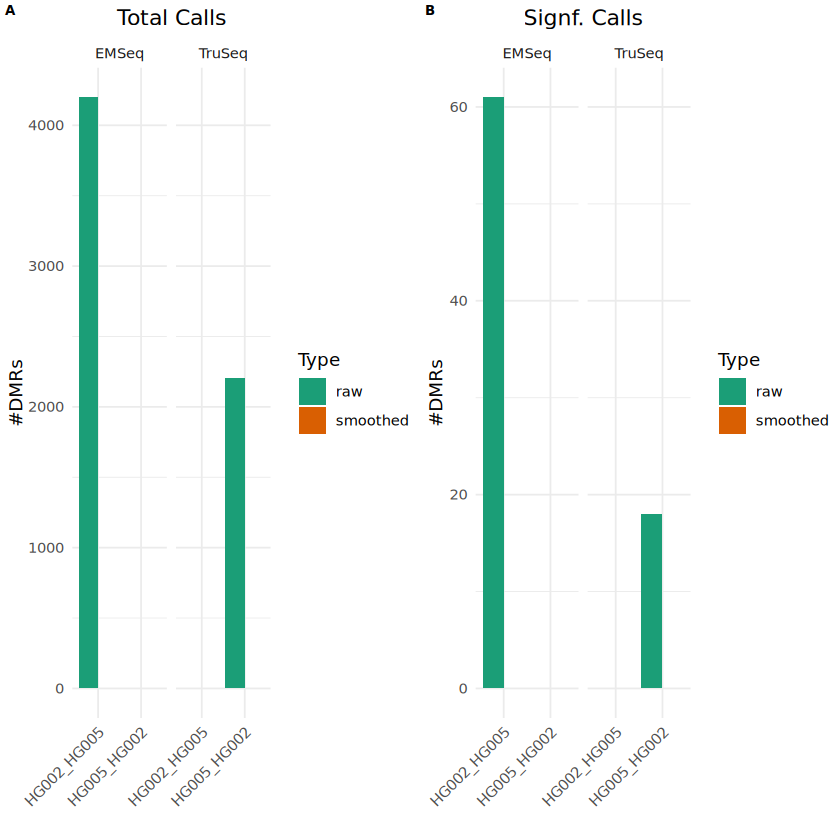

In [21]:
# Plot
plot1 <- ggplot(df_file_stats, aes(x = Group, y = count_total_calls, fill = Type)) +
  geom_bar(stat = "identity", position = "dodge") +
  facet_wrap(~ Seq) + scale_fill_manual(values = brewer.pal(3, "Dark2")) +
  labs(x = "", y = "#DMRs", title = "Total Calls") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
       plot.title = element_text(hjust = 0.5))

plot2 <- ggplot(df_file_stats, aes(x = Group, y = count_signf_calls, fill = Type)) +
  geom_bar(stat = "identity", position = "dodge") +
  facet_wrap(~ Seq) + scale_fill_manual(values = brewer.pal(3, "Dark2")) +
  labs(x = "", y = "#DMRs", title = "Signf. Calls") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
       plot.title = element_text(hjust = 0.5))

plot_compare <- plot_grid(plot1, plot2, labels = c('A', 'B'), label_size = 8)
plot_compare

pdf(file = paste0("/opt/notebooks/outputs/metilene/results/","compare_sr_dmr_counts.pdf"),
    width = 10, height = 5)
plot_compare
dev.off()


In [20]:
#
test1 <- read.table("outputs/metilene/results/GSM5649427_TruSeq_HG005_LAB01_REP02__GSM5649436_TruSeq_HG002_LAB01_REP02.raw.sr.metilene.out.tsv", 
    header = FALSE)

test1 <- test1 |> dplyr::mutate(row_id = seq_len(n()),
                                       Signf = case_when(V4<=0.1 ~ "Yes", TRUE ~ "No"))
#
# ggplot(test1) +
#   geom_segment(aes(x = V2, xend = V3, y = row_id, yend = row_id, color = Signf), size = 2) +
#   scale_color_manual(values = brewer.pal(3, "Set1")) +
#   labs(x = "Genomic Position", y = "Row Index", title = "Genomic Ranges Colored by Significance") +
#   theme_minimal()


###
# Create GRanges object with metadata
gr <- GRanges(
  seqnames = test1$V1,
  ranges = IRanges(start = test1$V2, end = test1$V3),
  Signf = test1$Signf
)

# Plot using ggbio
ggbio::autoplot(gr, aes(fill = Signf)) +
  scale_fill_manual(values = brewer.pal(3, "Set1")) +
  ggtitle("Genomic Ranges Colored by Significance") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
       plot.title = element_text(hjust = 0.5))

[1] 6405

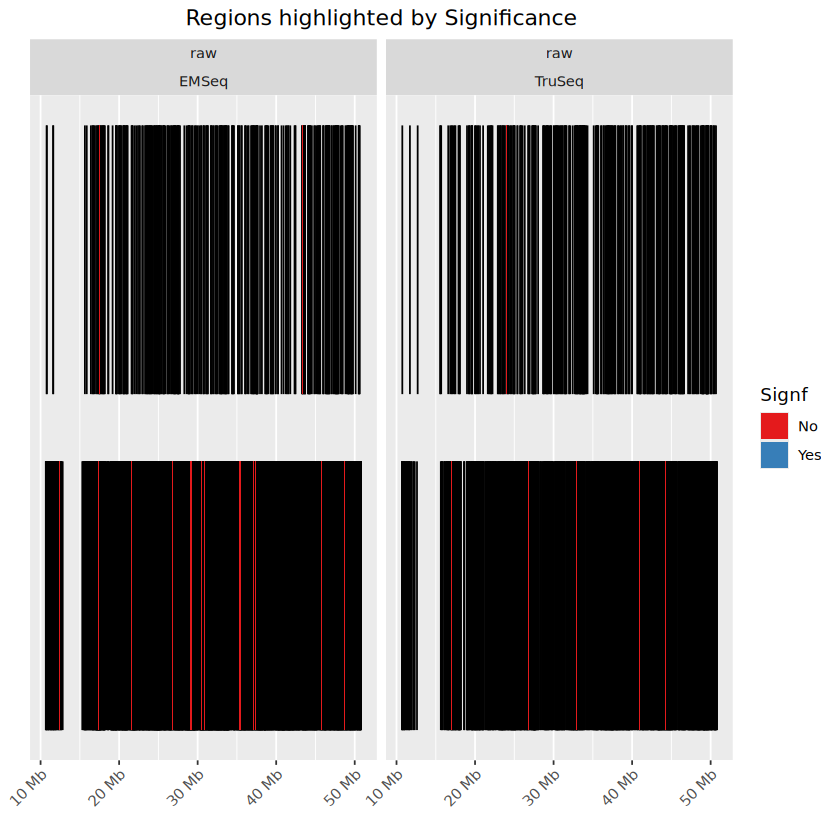

In [56]:
# Filtering for DMR files with data
metilene_out2 <- lapply(metilene_out1, function(file1) {
  size1 <- file.info(file1)$size  
  if (size1 != 0) {
    file1
  }
})
metilene_out2 <- metilene_out2[!sapply(metilene_out2, is.null)]  

# Combining data
df_all_calls <- lapply(metilene_out2, function(file1) {

  size1 <- file.info(file1)$size  
  if (size1 == 0) {
    next
  }
  df1 <- read.table(file1, header = FALSE)
  
  # Extract metadata from filename
  df1$Group1 <- sub("__.*", "", basename(file1))
  df1$Group1 <- sub(".*_HG", "HG", df1$Group1)
  df1$Group1 <- sub("_.*", "", df1$Group1)    
  df1$Group2 <- sub("\\..*", "", sub(".*__", "", basename(file1)))
  df1$Group2 <- sub(".*_HG", "HG", df1$Group2)
  df1$Group2 <- sub("_.*", "", df1$Group2)    
  df1$Type <- sub(".*\\.", "", sub(".sr.metilene.out.tsv", "", basename(file1)))
  df1$Seq <- sub(".*_", "", sub("_HG00[0-9].*", "", basename(file1)))
  
  return(df1)
})

#
df_all_calls <- do.call(rbind, df_all_calls)
df_all_calls <- df_all_calls |>
  dplyr::mutate(Group = paste(Group1, Group2, sep = "_"),
                Signf = case_when(V4<=0.1 ~ "Yes", TRUE ~ "No"))
nrow(df_all_calls)

#
gr <- GRanges(
  seqnames = df_all_calls$V1,
  ranges = IRanges(start = df_all_calls$V2, end = df_all_calls$V3),
  Signf = df_all_calls$Signf, Group1 = df_all_calls$Group1, Group2 = df_all_calls$Group2,
  Groupall = df_all_calls$Group, Seq = df_all_calls$Seq, Type = df_all_calls$Type
)

# Plot using ggbio
ggbio::autoplot(gr, aes(fill = Signf)) +
  scale_fill_manual(values = brewer.pal(3, "Set1")) +
  facet_wrap(Type ~ Seq) +
  ggtitle("Regions highlighted by Significance") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
       plot.title = element_text(hjust = 0.5))
